Course:
<br>https://aleksandarhaber.com/extended-kalman-filter-tutorial-with-example-and-disciplined-python-codes-part-ii-python-codes/

### Import libraries 

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import scipy
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

np.set_printoptions(suppress=True)

### Problem statement

<br>
We have a pendulum swinging on the rope. We will create simulation. As you can see from formula bellow, we should use sinus, which means, that we would be dealing with non linear system. For cases, where angle is bellow 15 degrees, we can approximate this value into linear system as is written in last formula
<img src="https://thecuriousastronomer.files.wordpress.com/2013/10/20131022-110640.jpg"  width = 300 height=300 />
<i>https://thecuriousastronomer.files.wordpress.com/2013/10/20131022-110640.jpg</i>


Firstly we define object of vehicle, where we will store all data

Then we run simulation of measurement and display real value of drivin

In [2]:
from scipy.integrate import odeint

In [3]:
def run_simulation(starting_angle:int=15,
                    length_of_rope:float = 10,
                    end_time:int = 10,
                    dt:float = 0.01,
                    g:float = 9.81, 
                    ):
    theta0 = np.deg2rad(starting_angle)

    # Set Initial State
    x0 = np.array([theta0,0])

    # total simulation time 
    totalSimulationTimeVector=np.arange(0,end_time,dt)

    # this state-space model defines the continuous dynamics of the pendulum
    # this function is passed as an argument of the odeint() function for integrating (solving) the dynamics 
    def stateSpaceModel(x,t):
        g=9.81
        # 
        l=1
        dxdt=np.array([x[1],-(g/l)*np.sin(x[0])])
        return dxdt

    # here we integrate the dynamics
    # the output: "solutionOde" contains time series of the angle and angular velocity 
    # these time series represent the time series of the true state that we want to estimate
    simulation_state_history=scipy.integrate.odeint(stateSpaceModel,x0,totalSimulationTimeVector)
    return simulation_state_history

In [4]:
simulation_state_history = run_simulation(    
                   starting_angle=35,
                   length_of_rope=1,
                   end_time = 5, 
                   dt=0.01)

<IPython.core.display.Javascript object>


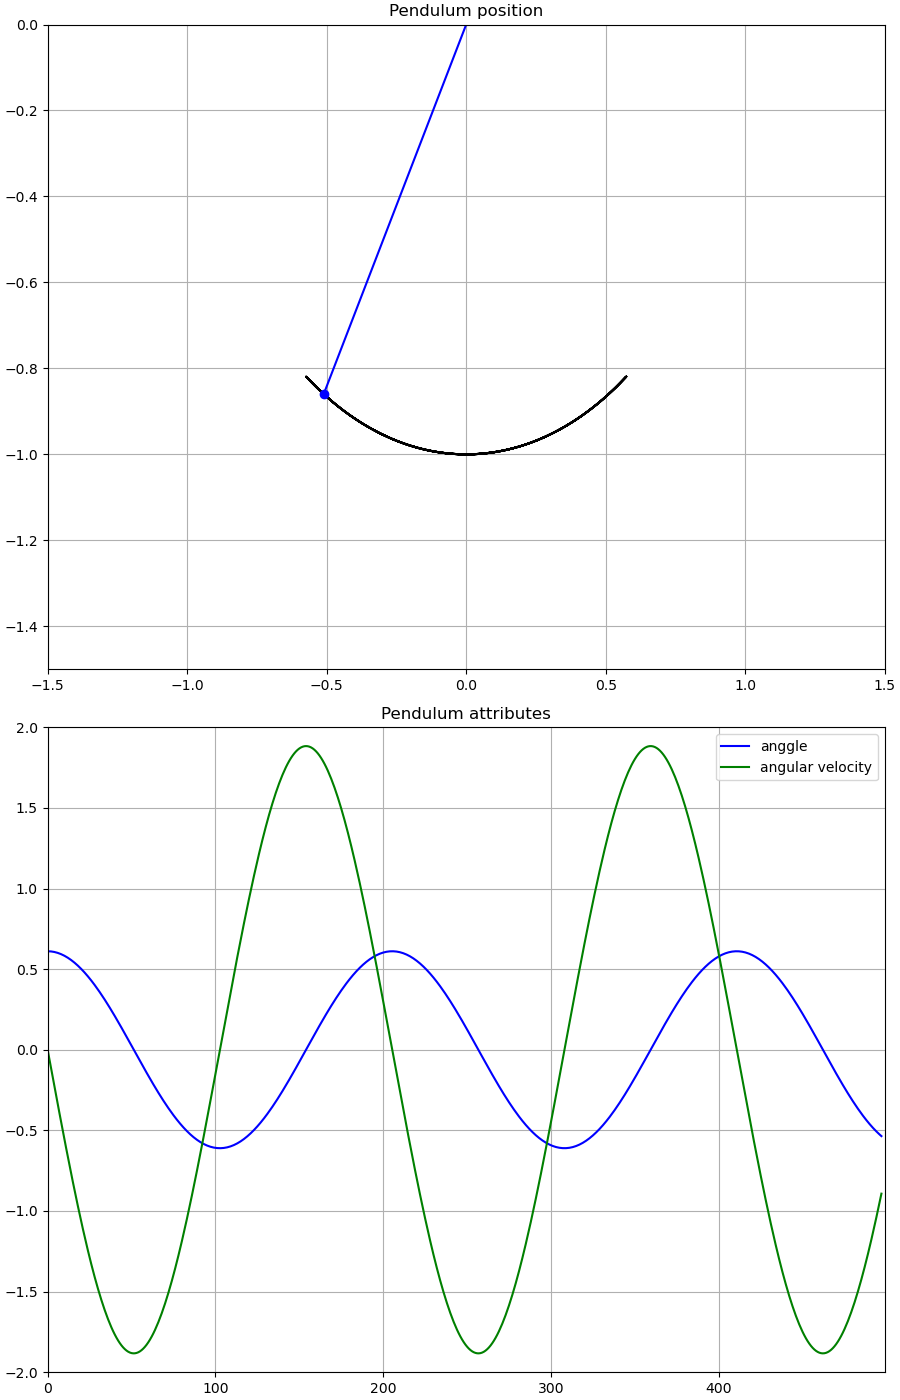

In [6]:
%matplotlib notebook
# Plot Animation
fig_of_plot, axes = plt.subplots(2,1, constrained_layout=True, figsize=(9,14))
axes[0].set_xlim((-1.5, 1.5))
axes[0].set_ylim((-1.5, 0))
axes[0].grid(visible=True)
axes[0].set_title('Pendulum position')
axes[1].grid(visible=True)
axes[1].set_title('Pendulum attributes')
axes[1].set_xlim((0, len(simulation_state_history)-1))
axes[1].set_ylim((-2, 2))


historical_movement, = axes[0].plot([],[],'-k')
rope, = axes[0].plot([], [], 'b-')
end_of_pendulum, = axes[0].plot([], [], 'bo')
angle, = axes[1].plot([], [], 'b-', label = "anggle")
angular_velocity, = axes[1].plot([], [], 'g-', label = "angular velocity")
axes[1].legend()

def update_plot(i):
    if i>1:
        lin_theta_history = np.array(simulation_state_history)[:i]
        first_values_history = lin_theta_history[:,0]
        lin_theta = first_values_history[-1]
        second_values_history = lin_theta_history[:,1]
        end_of_pendulum.set_data([np.sin(lin_theta),-np.cos(lin_theta)])
        historical_movement.set_data([np.sin(first_values_history),-np.cos(first_values_history)])
        rope.set_data([0,np.sin(lin_theta)],[0,-np.cos(lin_theta)])
        angle.set_data(np.arange(0, i, 1), first_values_history)
        angular_velocity.set_data(np.arange(0, i, 1), second_values_history)

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=len(simulation_state_history)-1, interval=1)


plt.show()

<h4>Lets implement prediction step of Kalman filter</h4>
We start with deriving our formula.
<ul>
  <li>Firstly we have angular position and angular rate, which we are trying to calculate</li>
  <li>In this formula, we can basicaly remove part of acceleration as we dont have these measurements. Also we need to linearized this model. In order to do that, we can assume, that up to 15 degrees, error in calculation would be up to 1%, to we can remove sinus</li>
  <li>Then we convert our formula into matrix form</li>
</ul>

<b>TODO Update image !!!</b>

<img src="images/Kalman_linearized_non_linear_pendulum.jpg"  width = 800 height=300 />

We define standard class for kalman filter as before. There are no changes

In [7]:
# Definition of Kalman filter
class KalmanFilterBase:
    def __init__(self):
        # variables we would like to track
        self.state = None
        self.covariance = None
        self.innovation = None
        self.innovation_covariance = None

    def get_current_state(self):
        if self.state is not None:
            return self.state.tolist()
        return None

    def get_current_covariance(self):
        if self.covariance is not None:
            return self.covariance.tolist()
        return None

    def get_last_innovation(self):
        if self.innovation is not None:
            return self.innovation.tolist()
        return None

    def get_last_innovation_covariance(self):
        if self.innovation_covariance is not None:
            return self.innovation_covariance.tolist()
        return None

In [149]:
# Kalman Filter Model
class KalmanFilterModel(KalmanFilterBase):
    def initialise(self, 
                   time_step, 
                   torque_std, 
                   meas_std, 
                   length = 0.5, 
                   init_on_measurement=False, 
                   init_pos_std = 0.1, 
                   init_vel_std = 0.1):
        self.dT = time_step
        self.init_pos_std = init_pos_std
        self.init_vel_std = init_vel_std
        self.currentTimeStep = 0
        self.g = 9.81
        self.l = length
        
        # Set Model F and H Matrices
        A = np.array([[0,1],[-9.81/length,0]])
        self.F = expm(A*time_step) # Note: use the expm() function
        self.H = np.array([[1,0]]) # Note: use np.array([[a,b]]) for a row matrix

        # Set R and Q Matrices
        self.Q = np.diag(np.array([0,1]) * (torque_std*torque_std)) # Note: use variable 'torque_std'
        self.R = np.array([[meas_std*meas_std]]) # Note: use variable 'meas_std'

        # Set Initial State and Covariance 
        if init_on_measurement is False:
            #self.state = np.transpose(np.array([[0.5,0.5]])) # Assume we are at zero position and velocity
            self.state = np.array([[-0.77926884],[-7.30010144]])
            self.covariance = np.diag(np.array([init_pos_std*init_pos_std,init_vel_std*init_vel_std]))
        
        return
    
    # here is the continuous state-space model
    # inputs:
    #       x - state vector 
    #       t - time
    # NOTE THAT WE ARE NOT USING time since the dynamics is time invariant
    # output: 
    #       dxdt - the value of the state function (derivative of x)
    def stateSpaceContinuous(self,x,t):
        dxdt=np.array([[x[1,0]],[-(self.g/self.l)*np.sin(x[0,0])]])
        return dxdt
     
    # this function defines the discretized state-space model 
    # we use the forward Euler discretization 
    # input: 
    #       x_k   - current state x_{k}
    # output:
    #       x_kp1 - state propagated in time x_{k+1}
    def discreteTimeDynamics(self,x_k):
        # note over here that we are not using "self.currentTimeStep*self.DT" since the dynamics is time invariant
        # however, you might need to use this argument if your dynamics is time varying
        x_kp1=x_k+self.dT*self.stateSpaceContinuous(x_k,self.currentTimeStep*self.dT)
        return x_kp1
     
    # this function returns the Jacobian of the discrete-time state equation 
    # evaluated at x_k
    # That is, it returns the matrix A
    # input: 
    #       x_k - state 
    # output: 
    #       A - the Jacobian matrix of the state equation with respect to state
    def jacobianStateEquation(self,x_k):
        A=np.zeros(shape=(2,2))
        A[0,0]=1
        A[0,1]=self.dT
        A[1,0]=-self.dT*(self.g/self.l)*np.cos(x_k[0,0])
        A[1,1]=1
        return A
    # this function returns the Jacobian of the output equation 
    # evaluated at x_k
    # That is, it returns the matrix C
    # Note that since in the case of the pendulum the output is a linear function 
    # and consequently, we actually do not use x_k
    # however, in the case of nonlinear output functions we need x_k
    # input: 
    #      x_k - state 
    # output: 
    #      C   - the Jacobian matrix of the output equation with respect to state
    def jacobianOutputEquation(self,x_k):
        C=np.zeros(shape=(1,2))
        C[0,0]=1
        return C
     
    # this is the output equation
    # input: 
    #       x_k - state
    # output: 
    #       x_k[0]- output value at the current state
    def outputEquation(self,x_k):
        return x_k[0]

    def prediction_step(self):
        # Make Sure Filter is Initialised
        if self.state is not None:
            x = self.state
            P = self.covariance

            # propagate the a posteriori estimate to compute the a priori estimate
            x_predict=self.discreteTimeDynamics(x)
            # linearize the dynamics at the a posteriori estimate 
            Akm1=self.jacobianStateEquation(x)
            # propagate the a posteriori covariance matrix in time to compute the a priori covariance
            P_predict=np.matmul(np.matmul(Akm1,P),Akm1.T)+self.Q
            self.currentTimeStep=self.currentTimeStep+1
            # Save Predicted State
            self.state = x_predict
            self.covariance = P_predict

        return

    def update_step(self, measurement):

        # Make Sure Filter is Initialised
        if self.state is not None and self.covariance is not None:
            x = self.state
            Ck = self.jacobianOutputEquation(x)
            P = self.covariance
            H = self.H
            R = self.R

            # Calculate Kalman Filter Update
            z = measurement
            z_hat = x
            y = z - self.outputEquation(z_hat)
            # keep in mind that the a priori indices start from k=1, that is why we index a priori quantities with "self.currentTimeStep-1"
            S= self.R+np.matmul(np.matmul(Ck,P),Ck.T)
            # Kalman gain matrix
            K=np.matmul(P,np.matmul(Ck.T,np.linalg.inv(S)))
            x_update = x+np.matmul(K,[y])
            IminusKkC=np.eye(x.shape[0])-np.matmul(K,Ck)
            P_update=np.matmul(IminusKkC,np.matmul(P,IminusKkC.T))+np.matmul(K,np.matmul(R,K.T))
            # Save Updated State
            self.innovation = y
            self.innovation_covariance = S
            self.state = x_update
            self.covariance = P_update

        else:
            # Set Initial State and Covariance 
            self.state = np.transpose(np.array([[measurement,0]]))
            self.covariance = np.diag(np.array([self.R,self.init_vel_std*self.init_vel_std])) # Assume we don't know our velocity

        return 

In [168]:
kf_options =  {'torque_std':0.1, # Q Matrix
              'meas_std':np.deg2rad(0.1), # R Matrix  
              'init_pos_std':np.deg2rad(10),
              'init_vel_std':np.deg2rad(10),
              'init_on_measurement':False, 
              'time_step': 0.01, 
              'length' : 10}

In [169]:
simulation_state_history = run_simulation(    
                   starting_angle=35,
                   length_of_rope=1,
                   end_time = 20, 
                   dt=0.01)

In [170]:
kalman_filter = KalmanFilterModel()
kalman_filter.initialise(**kf_options)

states = []
covariances = []
estimation_errors = []
for step_id in range(len(simulation_state_history)):
    # KF Prediction
    kalman_filter.prediction_step()
    kalman_filter.update_step(simulation_state_history[step_id][0])
    states.append(kalman_filter.get_current_state())
    covariances.append(kalman_filter.get_current_covariance())
    estimation_errors.append(np.array(kalman_filter.get_current_state()) 
                             - np.array(simulation_state_history[step_id]))

    
states = np.array(states)
covariances = np.array(covariances)
estimation_errors = np.array(estimation_errors)
lin_state_history = np.array(simulation_state_history)

<IPython.core.display.Javascript object>


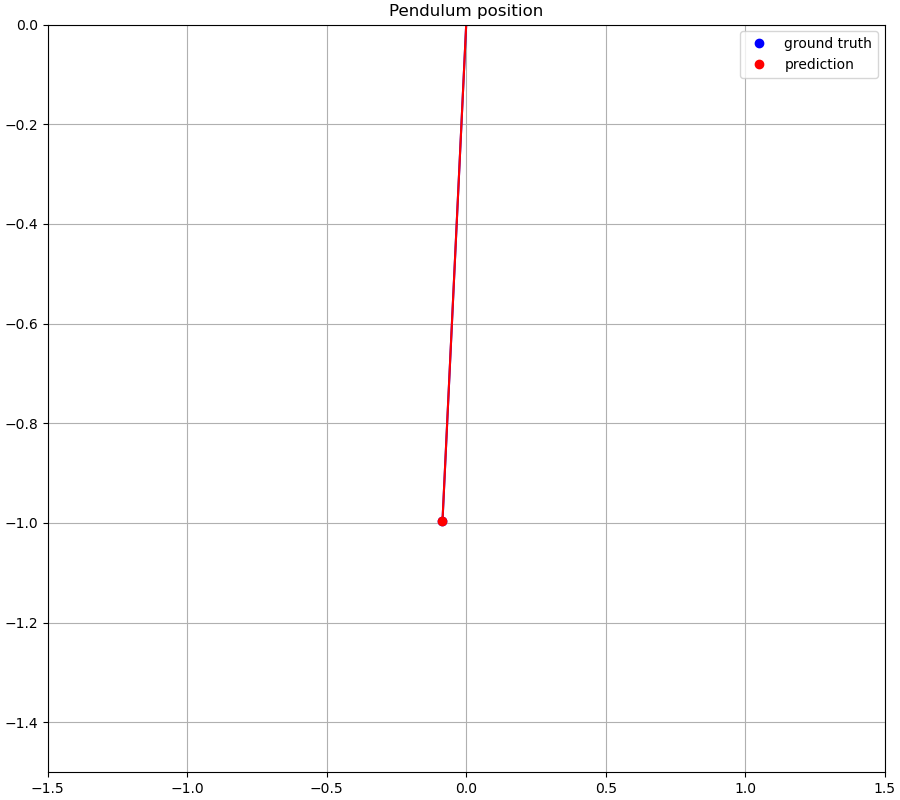

In [171]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot, axes = plt.subplots(constrained_layout=True, figsize=(9,8))
axes.set_xlim((-1.5, 1.5))
axes.set_ylim((-1.5, 0))
axes.grid(visible=True)
axes.set_title('Pendulum position')


rope_gt, = axes.plot([], [], 'b-')
end_of_pendulum_gt, = axes.plot([], [], 'bo', label = "ground truth")
rope_pred, = axes.plot([], [], 'r-')
end_of_pendulum_pred, = axes.plot([], [], 'ro', label = "prediction")

def update_plot(i):
    if i>1:
        pendulum_gt = lin_state_history[i,:]
        pendulum_pred = states[i,:]
        rope_gt.set_data([0,np.sin(pendulum_gt[0])],[0,-np.cos(pendulum_gt[0])])
        end_of_pendulum_gt.set_data([np.sin(pendulum_gt[0]),-np.cos(pendulum_gt[0])])
        rope_pred.set_data([0,np.sin(pendulum_pred[0])],[0,-np.cos(pendulum_pred[0])])
        end_of_pendulum_pred.set_data([np.sin(pendulum_pred[0]),-np.cos(pendulum_pred[0])])


ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=len(lin_state_history)-1, interval=10)

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


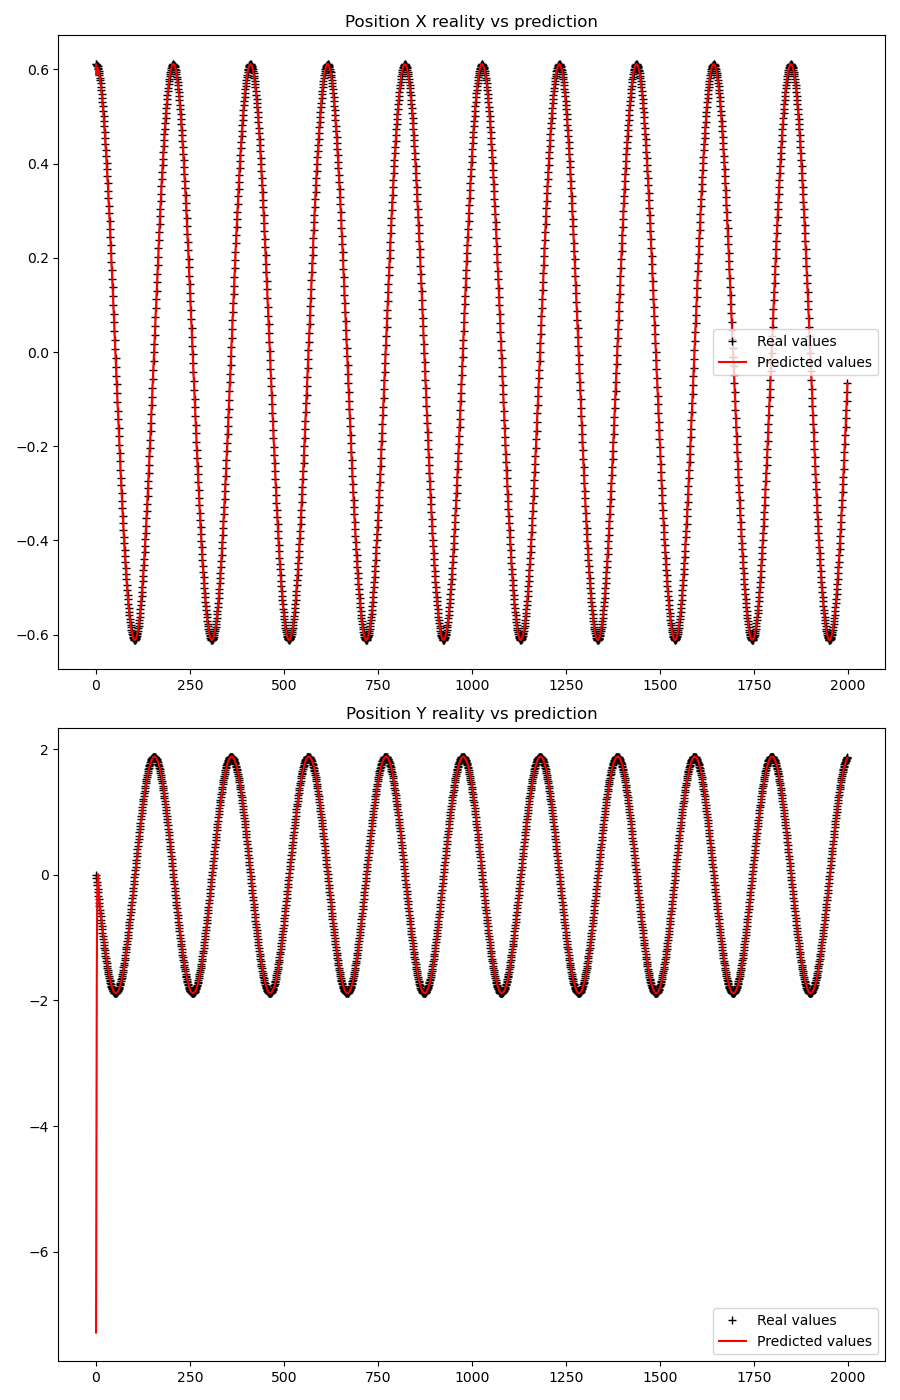

In [172]:
fig, ax = plt.subplots(2,1,figsize = (9,14))

ax[0].plot(lin_state_history[:,0], "+k", label = "Real values")
ax[0].plot(states[:,0], "-r", label = "Predicted values")
ax[0].legend()
ax[0].set_title("Position X reality vs prediction")

ax[1].plot(lin_state_history[:,1], "+k", label = "Real values")
ax[1].plot(states[:,1], "-r", label = "Predicted values")
ax[1].legend()
ax[1].set_title("Position Y reality vs prediction")


plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


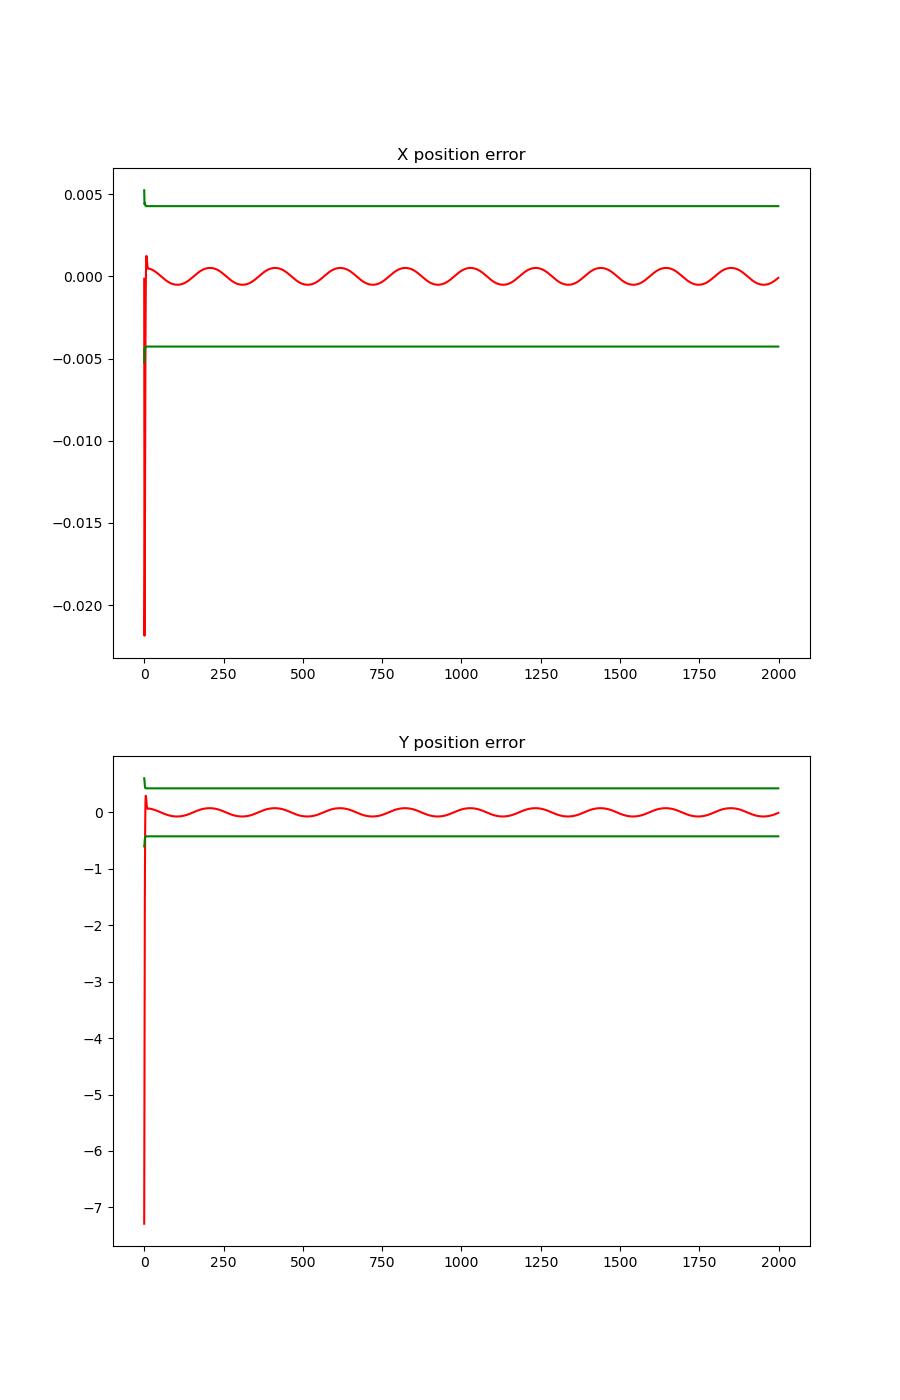

In [173]:
fig, ax = plt.subplots(2,1,figsize = (9,14))

ax[0].plot(states[:,0].reshape(-1,1,)-lin_state_history[:,0].reshape(-1,1,), "-r", label = "Difference in values")
ax[0].plot(3*np.sqrt(covariances[:,0,0]), "-g", label = "Upper 3 sigma")
ax[0].plot(-3*np.sqrt(covariances[:,0,0]), "-g", label = "Lower 3 sigma")
#ax[0].legend()
ax[0].set_title("X position error")

ax[1].plot(states[:,1].reshape(-1,1,)-lin_state_history[:,1].reshape(-1,1,), "-r", label = "Difference in values")
ax[1].plot(3*np.sqrt(covariances[:,1,1]), "-g", label = "Upper 3 sigma")
ax[1].plot(-3*np.sqrt(covariances[:,1,1]), "-g", label = "Lower 3 sigma")
#ax[1].legend()
ax[1].set_title("Y position error")

#plt.tight_layout()
plt.show()